In [1]:
import matplotlib.pylab as plt
import matplotlib
import ase.geometry
import numpy as np
import time
import ase
from ase.neighborlist import natural_cutoffs
from ase.io import read, write
from ase.visualize import view
from numpy.linalg import norm
from ase import neighborlist
from scipy import sparse

In [ ]:
start_time = time.time()
POS = read('POS_MERGED.xyz',index=':',format='xyz')
VEL = read('VEL_MERGED.xyz',index=':',format='xyz')

# Uncomment if needed
Time, Kin, Temp, Pot = [],[],[],[]# Conserved, Step, UsedTime = [],[],[]
with open('MERGED.ener','r') as enerFile:
    for l in enerFile.readlines():
        if '#' not in l:
#            #Step.append(l.split()[0])
             Time.append(float(l.split()[1]))
             Kin.append(float(l.split()[2]))
             Temp.append(float(l.split()[3]))
             Pot.append(float(l.split()[4]))
#            #Conserved.append(l.split()[5])
#            #UsedTime.append(l.split()[6])
            
# In case of mismatch tell the user!
if len(POS) != len(VEL) or len(POS) != len(Time) or len(VEL) != len(Time):
    print('Length of XYZ, VEL, ENER data are not the same!')
# Print length of the 3 lists
print('Number of steps:',len(POS),len(VEL),len(Time))

# Join positions and velocities in a single ase.Atoms object
for p,v in zip(POS,VEL):
    p.set_velocities(v.get_positions())
end_time = time.time() - start_time
print('Read in took: {:.3f} s'.format(end_time))

In [5]:
# Uncomment to check the difference between the
#  read KE and the calcualted one
for i in range(10):
    ke = POS[-i].get_kinetic_energy()/5.4857990e-4
    print (ke)
    print("{:.9f} vs {:.9f} = {:.2e}".format(ke,Kin[-i],ke-Kin[-i]))
print('If these numbers are not very similar (diff e-06/07), you should get upset!')

0.08717979165690143
0.087179792 vs 0.087179943 = -1.51e-07
0.16533602967567623
0.165336030 vs 0.165333888 = 2.14e-06
0.15868234819314941
0.158682348 vs 0.158680578 = 1.77e-06
0.15349505837647748
0.153495058 vs 0.153493580 = 1.48e-06
0.1496431149103123
0.149643115 vs 0.149641856 = 1.26e-06
0.14703194047385246
0.147031940 vs 0.147030834 = 1.11e-06
0.14560425235575575
0.145604252 vs 0.145603233 = 1.02e-06
0.14532943830171677
0.145329438 vs 0.145328434 = 1.00e-06
0.14619823920748432
0.146198239 vs 0.146197194 = 1.05e-06
0.1482256408650443
0.148225641 vs 0.148224488 = 1.15e-06
If these numbers are not very similar (diff e-06/07), you should get upset!


#Conversion of units

  1 bohr           =  0.529177249      angstrom
  1 hartree        =  27.2113961       eV
                   =  219474.63068     cm^-1
                   =  627.50956        kcal/mol
  1 electron mass  =  5.4857990e-4     u ( unified atomic mass unit)
                   =  9.1093897e-31    kg
  1 cal            =  4.184            J  (by definition)
  N_avogadro       =  6.0221367e23     (per mol)
  1 Debye          =  0.393456         a.u.
  
Atomic masses (including electrons) of most abundant isotope in a.m.u.
  H     1.007825
  D     2.0140
  He    4.0026
  C    12
  N    14.00307
  O    15.99491
  F    18.9984
  S    31.97207
  Cl   34.96885

In [6]:
def shiftCenter(a,new_center):
    '''This function
    shifts the position of
    each atom in an ase.Atoms
    object.
    Input: Atom object and new_center
    Output: Atom object with new positions
    '''
    new_pos=[]
    for x_old,y_old,z_old in a.get_positions():
        x=x_old-new_center[0]
        y=y_old-new_center[1]
        z=z_old-new_center[2]
        new_pos.append((x,y,z))
    return a.set_positions(new_pos)

# Make cell and put all atoms in, centering upon the rx site
def add_cell(a,cell,recenter=[0,0,0]):
    '''This function adds a Cell to 
    each Atoms object (all along the
    simulation) and shifts all atomic
    positions into a newly defined center
    by calling shitCenter(a,new_center).
    Input: a :: ase.Atoms,cell :: list len =3,
    recenter :: list len=3.
    Output: Updated ase.Atoms object.
    '''
    shiftCenter(a,recenter) # center to atom and cell
    a.set_cell(cell)
    a.set_pbc([1,1,1])
    a.wrap()
    return a

# Some handy functions
def inRange(v,rang):
    if min(rang) < v < max(rang): return True
    else: return False
def inBox(lims,A):
    inside = []
    for a in A:
        if  inRange(a.x,lims[0]) and inRange(a.y,lims[1]) and inRange(a.z,lims[2]):
            inside.append(a.index)
    return inside
def inSph(rads,A,c):
    inside = []
    for a in A:
        if inRange(np.sqrt((a.x-c[0])**2+(a.y-c[1])**2+(a.z-c[2])**2),rads):
            inside.append(a.index)
    return inside
def inLay(lims_z,A):
    inside = []
    for at in A:
        if inRange(at.z,lims_z):
            inside.append(at.index)
    return inside

def RebuildMolec(A):
    '''Function that reconstructs the molecules out of the atoms
It is slow, so better to just call it once at the 
beginning of the main func.'''
    cutOff = natural_cutoffs(A)
    neighborList = neighborlist.NeighborList(cutOff, self_interaction=False, bothways=True)
    neighborList.update(A)
    matrix = neighborList.get_connectivity_matrix()
    n_components, component_list = sparse.csgraph.connected_components(matrix)
    return n_components, component_list

# Main function
def WatInside(A,box_sizes,spheres,n_lay,cell_p,box_trigger=True,sph_trigger=True,lay_trigger=True):# A is an atoms object
    '''
    ============================== WatInside =========================================
    Input:
    A :::::::::::::: ase atoms object
    box_sizes, 
     spheres, 
      n_lay :::::::: slections to be perfromed
    cell_p ::::::::: cell parameters
    *_trigger :::::: logic True/False
    Output:
    3 numpy arrays containing atom indeces from A according to the selection patterns
    Summary:
    For each selection pattern, e.g. shell-like boxes, spheres or just layers
    this function will return the indeces of the atoms, oxy-atoms and water molecules
    whose oxy-atoms lie inside the selections.
    E.g.
    Imagine I want to select the 3 layers the next system:
       CELL             SELECTION
    ::::::::::         ::::::::::     
    :        :         :        :
    :        :         :        :
    :oooooooo:   f()   :--------:
    :oooooooo:  ---->  :oooooooo:  
    :oooooooo:         :--------:
    ::::::::::         :oooooooo:
                       :--------:
                       :oooooooo:
                       :--------:
                       ::::::::::
    where f() is this function.
    Same for xyz and radial shells.
    =================================================================================='''
    c = cell_p/2 # center of the cell
    n_components, component_list = RebuildMolec(A)
    #--------------------#
    #:::::: BOXES :::::::#
    #--------------------#
    if box_trigger:
        AT_PERBOX_IN_idx     = [0 for i in box_sizes]
        WATERS_PERBOX        = AT_PERBOX_IN_idx[:]
        WATERS_PERBOX_IN_idx = AT_PERBOX_IN_idx[:]
        #
        for j,factor in enumerate(box_sizes):
            lims = np.asarray([ [0,0],[0,0],[0,0] ])
            for i in range(len(lims)): 
                lims[i][0],lims[i][1] = c[i]-cell_p[i]*factor/2, c[i]+cell_p[i]*factor/2
            AT_PERBOX_IN_idx[j] =  inBox(lims,A)
        # Make shells
        prev = []
        for j in range(len(AT_PERBOX_IN_idx[1:])):
            j=j+1
            prev.extend(AT_PERBOX_IN_idx[j-1])
            AT_PERBOX_IN_idx[j] = [at_idx for at_idx in AT_PERBOX_IN_idx[j] if at_idx not in prev]
        OXY_PERBOX_IN_idxs    = [ [idx for idx in idx_a_inside if A[idx].number == 8] for idx_a_inside in AT_PERBOX_IN_idx ]
        ## REBUILD THE MOLECULES 
        WATERS_PERBOX         = [ [component_list[idx] for idx in OXY_idxs] for OXY_idxs in OXY_PERBOX_IN_idxs ]
        WATERS_PERBOX_IN_idx  = [ [i for i in range(len(component_list)) if component_list[i] in waters] for waters in WATERS_PERBOX ]
    else: AT_PERBOX_IN_idx,OXY_PERBOX_IN_idxs,WATERS_PERBOX_IN_idx = [],[],[]
    #----------------------#
    #:::::: SPHERES :::::::#
    #----------------------#
    if sph_trigger:
        # Create some lists
        AT_PERSPH_IN_idx     = [0 for i in spheres]       
        WATERS_PERSPH        = AT_PERSPH_IN_idx[:]
        WATERS_PERSPH_IN_idx = AT_PERSPH_IN_idx[:]
        rads = [0,spheres[0]]
        AT_PERSPH_IN_idx[0] = inSph(rads,A,c)
        for j,sph in enumerate(spheres[1:]):
            j=j+1
            rads = [spheres[j-1],sph]
            AT_PERSPH_IN_idx[j] = inSph(rads,A,c)
        OXY_PERSPH_IN_idxs = [ [idx for idx in idx_a_inside if A[idx].number == 8] for idx_a_inside in AT_PERSPH_IN_idx ]
        WATERS_PERSPH         = [ [component_list[idx] for idx in OXY_idxs] for OXY_idxs in OXY_PERSPH_IN_idxs ]
        WATERS_PERSPH_IN_idx  = [ [i for i in range(len(component_list)) if component_list[i] in waters] for waters in WATERS_PERSPH ]
    else: AT_PERSPH_IN_idx,OXY_PERSPH_IN_idxs,WATERS_PERSPH_IN_idx = [],[],[]
    #---------------------#
    #:::::: LAYERS :::::::#
    #---------------------#
    # Get the O with highest z coordinate in order to get a starting point for the layers
    if lay_trigger:
        at_z = np.asarray([[ind,at.z] for ind,at in enumerate(A) if at.number == 8]).transpose()
        zO_top     , zO_bot      =  max(at_z[1]), min(at_z[1])
        idx_top_oxy, idx_bot_oxy = int(at_z[0][ np.argmax(at_z[1]) ]) , int(at_z[0][ np.argmin(at_z[1]) ])
        dlay = (zO_top-zO_bot)/n_lay
        dz   = 0.2 # Angs
        # Create some lists
        AT_PERLAY_IN_idx     = [0 for i in range(n_lay)]       
        WATERS_PERLAY        = AT_PERLAY_IN_idx[:]
        WATERS_PERLAY_IN_idx = AT_PERLAY_IN_idx[:]
        # Loop over the number of layers
        for il in range(n_lay):
            lims = [ A[idx_top_oxy].z+dz-dlay*il, A[idx_top_oxy].z-dz - dlay*(il+1)]
            AT_PERLAY_IN_idx[il] = inLay(lims,A)
        OXY_PERLAY_IN_idxs    = [ [idx for idx in idx_a_inside if A[idx].number == 8] for idx_a_inside in AT_PERLAY_IN_idx ]
        WATERS_PERLAY         = [ [component_list[idx] for idx in OXY_idxs] for OXY_idxs in OXY_PERLAY_IN_idxs ]
        WATERS_PERLAY_IN_idx  = [ [i for i in range(len(component_list)) if component_list[i] in waters] for waters in WATERS_PERLAY ]
    else: AT_PERLAY_IN_idx,OXY_PERLAY_IN_idxs,WATERS_PERLAY_IN_idx = [],[],[]
    
    # Collect data sets
    BOXES_DATA   = [AT_PERBOX_IN_idx,OXY_PERBOX_IN_idxs,WATERS_PERBOX_IN_idx]
    SPHERES_DATA = [AT_PERSPH_IN_idx,OXY_PERSPH_IN_idxs,WATERS_PERSPH_IN_idx]
    LAYERS_DATA  = [AT_PERLAY_IN_idx,OXY_PERLAY_IN_idxs,WATERS_PERLAY_IN_idx]
    # Return data
    return BOXES_DATA, SPHERES_DATA, LAYERS_DATA

In [8]:
#view(POS[0])

In [15]:
# Cell lengths (a,b,c)
#cell=[13.159, 14.165, 25.0]
#cell=[0.3315336E+02*0.529177, 0.4015196E+02*0.529177, 0.6614041E+02*0.529177]
cell=[0.497338319692655E+02*0.529177, 0.535359624473475E+02*0.529177, 0.944863438887178E+02*0.529177] #Da convertire da angstrom a bohr
# Position of RX center
# Atom_id_to_center_on:
a_id_c = 1728 # the atom to center on (uno dei due carboni dell'iCOM, il meno mobile)
new_center=np.asarray(POS[0].get_positions()[a_id_c])-np.asarray(cell)/2 # get new center (C atom, #0 in 1st frame) and center of cell
for p in POS:
    if not p.get_cell().any(): # if all get_cell params are 0 (cell unset)
        p=add_cell(p,cell,new_center)
        
        
#######################################################################
#::::::::::::::::::::::::: MODIFY ME!! :::::::::::::::::::::::::::::::#
#######################################################################
# Set the frames to be read:
fr0,frF=0,2361#000

# Get cell params (x,y,z)
cell = POS[0].get_cell_lengths_and_angles()[0:3]

# Set shells (boxes and spheres)
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::: MODIFY HERE
CellDiag   = np.sqrt(cell[0]**2+cell[1]**2+cell[2]**2) # major diagonal of the cell, used for max radius
print("Major cell's diagonal:",CellDiag)
Box_sizes  = sorted(np.linspace(0.34,1,7), key=float)       # multiplicative factor (factor*cell=external box)
Sph_sizes  = sorted(np.linspace(4,31,6), key=float) # radius in Angs (where the sphere begins) # CellDiag/2 (from the last print) #number of layers
n_lay      = 4 # number of layers

box_trigger = False
sph_trigger = True
lay_trigger = False
# If in case you just want to run the selection of atoms
# at the 1st frame of your selection, the next variable
# must be set to True.
just_1st = True
tstep = 0.5

radical = [1728,1729]#[0,1,218]Molecola adsorbita
#selection = [2,8,26] #Tutta la superficie, o una molecola o atomo specifici
selection = range(0,1728,1) 
print (selection)
#######################################################################
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::#
#######################################################################

Major cell's diagonal: 63.20780034141359
range(0, 1728)


In [11]:
#view(POS)

In [16]:
FRAMES = POS[fr0:frF]
# Init DATA matrices for boxes (_b) and spheres (_sp)
DATA_b           = np.zeros(shape=(len(Box_sizes),len(FRAMES)))
DATA_b_massindp  = np.copy(DATA_b)
DATA_b_perWnumb  = np.copy(DATA_b)
DATA_sp          = np.zeros(shape=(len(Sph_sizes),len(FRAMES)))
DATA_sp_massindp = np.copy(DATA_sp)
DATA_sp_perWnumb = np.copy(DATA_sp)
DATA_l           = np.zeros(shape=(n_lay,len(FRAMES)))
DATA_l_massindp  = np.copy(DATA_l)
DATA_l_perWnumb  = np.copy(DATA_l)

kinE_react          = np.zeros(shape=(len(FRAMES)))
kinE_react_massindp = np.copy(kinE_react)

kinE_selH2O          = np.zeros(shape=(len(FRAMES)))
kinE_selH2O_massindp = np.copy(kinE_react)


######################
##### MAIN LOOP ######
#####...........######
# For each frame, get the idxs of atoms inside (except those from the radicals)
start_time = time.time()
for fr_idx,fr in enumerate(FRAMES):
    # kin. Energy of reactants:
    kinE_react[fr_idx]          = fr[radical].get_kinetic_energy()/5.4857990e-4  
    kinE_react_massindp[fr_idx] = fr[radical].get_kinetic_energy()/(sum(fr[radical].get_masses()))
    
    kinE_selH2O[fr_idx]          = fr[selection].get_kinetic_energy()/5.4857990e-4  
    kinE_selH2O_massindp[fr_idx] = fr[selection].get_kinetic_energy()/(sum(fr[selection].get_masses()))
    
    atoms     = fr.copy()
    del atoms[ radical ] # remove the radical ####################### MODIFY IF NEEDED ####
    #--------------------#
    #:::::: DATA! :::::::#
    # Each data pack contains three
    # lists: atoms, oxygens and 
    # reconstructed water molecules
    # all inside the defined shells.
    #--------------------#
    if [just_1st,fr_idx] == [True,0] or just_1st == False:
        BOXES_DATA,SPHERES_DATA,LAYERS_DATA = WatInside(atoms,Box_sizes,Sph_sizes,n_lay,cell,box_trigger,sph_trigger,lay_trigger)

        ATOMS_B, OX_B, WAT_B = BOXES_DATA
        ATOMS_S, OX_S, WAT_S = SPHERES_DATA
        ATOMS_L, OX_L, WAT_L = LAYERS_DATA
        
        #print('Selection... Frame = {}'.format(fr_idx))
    
    #--------------------#
    #:::::: BOXES :::::::#
    #--------------------#
    if box_trigger:
        for i,shell in enumerate(WAT_B):
            DATA_b[i,fr_idx]          = atoms[shell].get_kinetic_energy()/5.4857990e-4
            DATA_b_massindp[i,fr_idx] = atoms[shell].get_kinetic_energy()/(sum(atoms[shell].get_masses()))
            DATA_b_perWnumb[i,fr_idx] = atoms[shell].get_kinetic_energy()/(len(atoms[shell])/3)/5.4857990e-4
            #view(atoms[shell])
    ##-----------------##
    ###### SPHERES ######
    ##-----------------##
    if sph_trigger:
        for i,shell in enumerate(WAT_S):
            DATA_sp[i,fr_idx]          = atoms[shell].get_kinetic_energy()/5.4857990e-4
            DATA_sp_massindp[i,fr_idx] = atoms[shell].get_kinetic_energy()/(sum(atoms[shell].get_masses()))
            DATA_sp_perWnumb[i,fr_idx] = atoms[shell].get_kinetic_energy()/(len(atoms[shell])/3)/5.4857990e-4
            #print('Atoms per shell ({:d}):'.format(i),len(atoms[shell])/3)
            #view(atoms[shell])
    #---------------------#
    #:::::: LAYERS :::::::#
    #---------------------#
    if lay_trigger:
        for i,shell in enumerate(WAT_L):
            DATA_l[i,fr_idx]          = atoms[shell].get_kinetic_energy()/5.4857990e-4
            DATA_l_massindp[i,fr_idx] = atoms[shell].get_kinetic_energy()/(sum(atoms[shell].get_masses()))
            DATA_l_perWnumb[i,fr_idx] = atoms[shell].get_kinetic_energy()/(len(atoms[shell])/3)/5.4857990e-4
            #if fr_idx == 50:
            #    view(atoms[shell])
#####...........######
######################
end_time = time.time() - start_time

print(kinE_react[0])
print(fr[selection])
print('Time: {:.3f} s ({:.2f} min) for {:d} frames'.format(end_time,end_time/60,len(FRAMES)))
if box_trigger: print('DATA for boxs is a {:d}x{:d} matrix'.format(len(DATA_b[0]) ,len(DATA_b) ))
if sph_trigger: print('DATA for sphs is a {:d}x{:d} matrix'.format(len(DATA_sp[0]),len(DATA_sp)))
if lay_trigger: print('DATA for lays is a {:d}x{:d} matrix'.format(len(DATA_l[0]) ,len(DATA_l) ))

0.0
Atoms(symbols='H1152O576', pbc=True, cell=[26.318000000000012, 28.33000000000001, 50.00000000000002], momenta=...)
Time: 8.776 s (0.15 min) for 2361 frames
DATA for sphs is a 2361x6 matrix


In [17]:
##-----------------##
#### File saving ####
##-----------------##

names    = ['sph_massindp',  'sph', 'sph_perWnumb',
            'box_massindp','box', 'box_perWnumb',
            'lay_massindp',  'lay', 'lay_perWnumb']
matrices = [DATA_sp_massindp, DATA_sp, DATA_sp_perWnumb,
            DATA_b_massindp, DATA_b, DATA_b_perWnumb,
            DATA_l_massindp, DATA_l, DATA_l_perWnumb ]
#names    = ['sph_massindp',  'box_massindp',  'lay_massindp']
#matrices = [DATA_sp_massindp,DATA_b_massindp, DATA_l_massindp ]
for n,mat in zip(names,matrices):
    with open(n+'.csv','wb') as f:
        if 'box' in n:
            head='''Cell size: {}. Units: a.u. 
Rows:: {} frames ,Cols:: {} box like shells. 
In order to plot you need to transpose the mat.
Max box factor: {} (MaxBox = factor*cell)'''.format(cell,len(mat),len(mat[0]),[float('{:.3f}'.format(i)) for i in Box_sizes])
        elif 'sph' in n:
            head='''Cell size: {}. Units: a.u. 
Rows:: {} frames ,Cols:: {} sphere like shells. 
In order to plot you need to transpose the mat.
Max Radius {}'''.format(cell,len(mat),len(mat[0]),[float('{:.3f}'.format(i)) for i in Sph_sizes])
        elif 'lay' in n:
            head='''Cell size: {}. Units: a.u.
Rows:: {} frames ,Cols:: {} layer num (from top to bott).
In order to plot you need to transpose the mat.
Layer: {}'''.format(cell,len(mat),len(mat[0]),[float('{:d}'.format(i+1)) for i in range(n_lay)])
        np.savetxt(f, mat.transpose(), fmt='%1.8e',delimiter=',',header=head,comments='#')

with open('reactants_kinE.csv','w') as f:
#    head='''Cell size: {}. Units: a.u. 
#Rows:: {} frames ,Cols:: 1.'''.format(cell,len(kinE_react_massindp))
#    np.savetxt(f,np.asarray([[i*tstep for i in range(len(kinE_react_massindp))],kinE_react_massindp]).transpose(),fmt='%1.8e',delimiter=',',header=head,comments='#')
    head='''Cell size: {}. Units: a.u. 
Rows:: {} frames ,Cols:: 1.'''.format(cell,len(kinE_react))
    np.savetxt(f,np.asarray([[i*tstep for i in range(len(kinE_react))],kinE_react]).transpose(),fmt='%1.8e',delimiter=',',header=head,comments='#')

with open('selection_kinE.csv','w') as f:
    head='''Cell size: {}. Units: a.u. 
Rows:: {} frames ,Cols:: 1.'''.format(cell,len(kinE_selH2O))
    np.savetxt(f,np.asarray([[i*tstep for i in range(len(kinE_selH2O))],kinE_selH2O]).transpose(),fmt='%1.8e',delimiter=',',header=head,comments='#')
    
    
print('Done')

Done


In [207]:
##--------------------##
#### Matrix loading ####
#### from file.     ####
##--------------------##
#names    = ['sph_massindp',  'sph',  'box_massindp','box',  'lay_massindp',  'lay']
#matrices = [DATA_sp_massindp,DATA_sp,DATA_b_massindp,DATA_b, DATA_l_massindp, DATA_l ]
#for n,mat in zip(names,matrices):
#    with open(n+'.csv','wb') as f:
#        mat=np.loadtxt(f,dtype=float,comments='#', delimiter=',').transpose()

##-----------------##
#### 2D plotting ####
##-----------------##
#for myDATA in [DATA_b,DATA_b_massindp]:
#    myDATA=myDATA*2625.5 # Hartrees to kJ/mol
#    extent = [fr0,frF,min(Box_sizes),max(Box_sizes)]
#    fig, ax = plt.subplots(figsize=(6,3))
#    im=ax.imshow(myDATA,cmap=plt.cm.Reds,interpolation='nearest',aspect='auto',origin='lower',extent=extent)
#    cbar = fig.colorbar(im, orientation='vertical')
#    ax.set_xlabel('Time')
#    ax.set_ylabel(r'Box/Cell, $N$')
#    plt.show()
#for myDATA in [DATA_sp,DATA_sp_massindp]:
#    myDATA=myDATA*2625.5 # Hartrees to kJ/mol
#    extent = [fr0,frF,min(Sph_sizes),max(Sph_sizes)]
#    fig, ax = plt.subplots(figsize=(6,3))
#    im=ax.imshow(myDATA,cmap=plt.cm.Reds,interpolation='nearest',aspect='auto',origin='lower',extent=extent)
#    cbar = fig.colorbar(im, orientation='vertical')
#    ax.set_xlabel('Time')
#    ax.set_ylabel(r'Radius ($\AA$)')
#    plt.show()   

### Plotting reactants' & selected atoms Kin energy

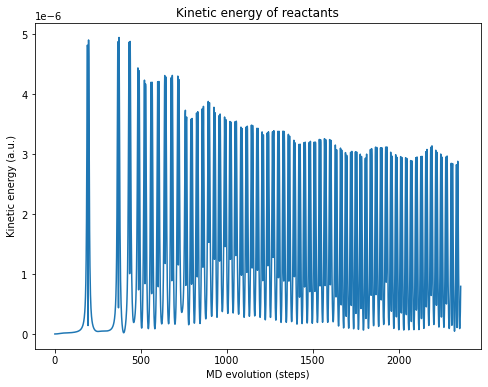

In [18]:
fig, ax= plt.subplots(nrows=1, ncols=1,figsize=(8,6)) 
ax.plot(range(len(kinE_react_massindp)),kinE_react_massindp)
ax.set_title(r'Kinetic energy of reactants')
ax.set_xlabel('MD evolution (steps)')
#ax.set_xlabel('Time ()')
ax.set_ylabel('Kinetic energy (a.u.)')
plt.savefig("kinE_reactants.png", dpi=300)
plt.show()

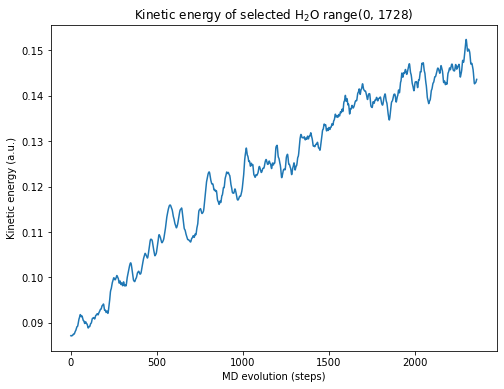

In [19]:
fig, ax= plt.subplots(nrows=1, ncols=1,figsize=(8,6)) 
ax.plot(range(len(kinE_selH2O)),kinE_selH2O)
ax.set_title(r'Kinetic energy of selected H$_2$O {}'.format(selection))
ax.set_xlabel('MD evolution (steps)')
#ax.set_xlabel('Time ()')
ax.set_ylabel('Kinetic energy (a.u.)')
plt.savefig("kinE_reactants.png", dpi=300)
plt.show()

### Plotting spherical energy dispersion for different spherical radius

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


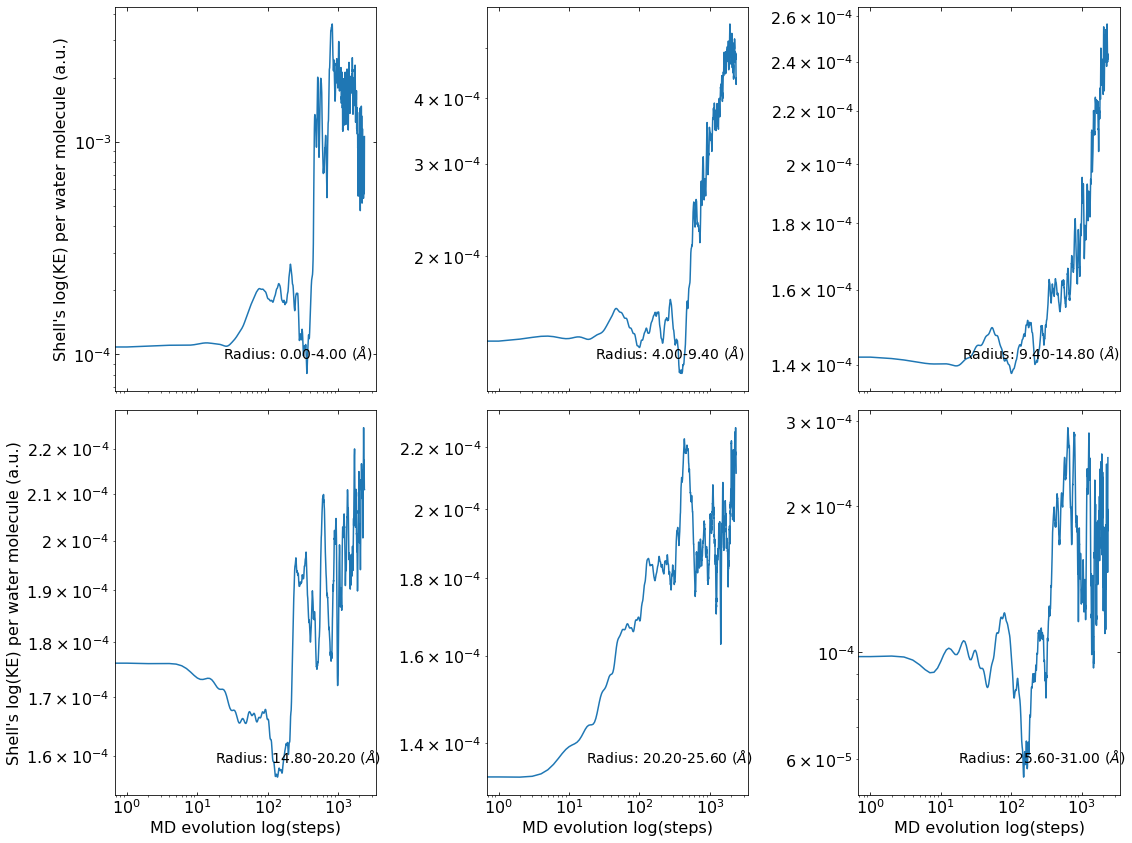

In [20]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
##### MODIFY NCols and NRows if needed
fig, axes= plt.subplots(nrows=int((len(Sph_sizes)-3-1)), ncols=3,figsize=(16,12)) 
axs = axes.reshape(len(Sph_sizes))
for ax,sph,k in zip(axs,Sph_sizes,range(len(Sph_sizes))):
    #ax.plot(range(len(DATA_sp_massindp[k][:])) , DATA_sp_massindp[k][:])
    ax.plot(range(len(DATA_sp_perWnumb[k][:])) , DATA_sp_perWnumb[k][:])
    if k==0:
        previous_radius = 0
    else:
        previous_radius = Sph_sizes[k-1]
    label = r'Radius: {:.2f}-{:.2f} ($\AA$)'.format(previous_radius,sph)
    ax.text(0.7,0.1,label, ha='center',va='center', transform=ax.transAxes,fontsize=14)
    #ax.set_xlabel('MD evolution (steps)')
    ax.tick_params(axis='both', direction='in', which='major',bottom=True,top=True,left=True,right=True)
    # Remove if unneded:
    ax.set_xscale('log')
    ax.set_yscale('log')

for ax in axs[0:3]:
    ax.tick_params(labelbottom=False)
for ax in [axs[0],axs[3]]:
    # Remove if neded:
    #ax.set_ylabel("Shell's KE ($a_0^2/s^2$)")
    ax.set_ylabel("Shell's log(KE) per water molecule (a.u.)")
for ax in axs[3:]:
    # Remove if neded:
    #ax.set_xlabel('MD evolution (steps)')
    ax.set_xlabel('MD evolution log(steps)')
fig.tight_layout()
plt.savefig("spherical_shells.png", dpi=600)
plt.show()
#for k,sph in enumerate(Sph_sizes):
#    plt.plot( range(len(DATA_sp_massindp[k][:])) , DATA_sp_massindp[k][:])
#    #plt.xticks(np.linspace(0, frF, 100)+[len(FRAMES)])
#    plt.title(r'Radius: {:.2f} ($\AA$)'.format(sph))
#    plt.savefig("filename"+str(sph)+'.png', dpi=300)
#    plt.show()

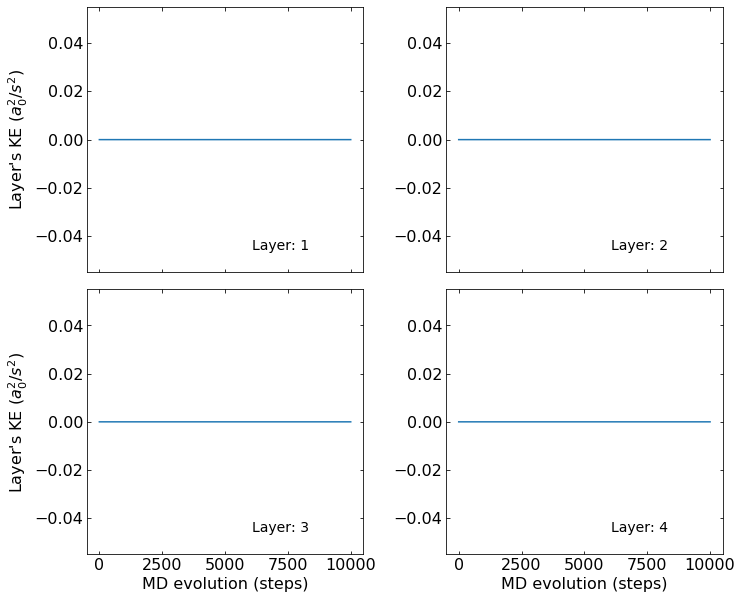

In [25]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
##### MODIFY NCols and NRows if needed
fig, axes= plt.subplots(nrows=2, ncols=2,figsize=(10.6,8.6)) 
axs = axes.reshape(n_lay) #there are just 3 layers! I leave one spot empty
for ax,k in zip(axs,range(n_lay)): # is the position in the list and the layer number
    ax.plot(range(len(DATA_l_massindp[k][:])) , DATA_l_massindp[k][:])
    label = r'Layer: {:d}'.format(k+1) # layer numb = k+1
    ax.text(0.7,0.1,label, ha='center',va='center', transform=ax.transAxes,fontsize=14)
    #ax.set_xlabel('MD evolution (steps)')
    ax.tick_params(axis='both', direction='in', which='major',bottom=True,top=True,left=True,right=True)

for ax in axs[0:2]:
    ax.tick_params(labelbottom=False)
for ax in [axs[0],axs[2]]:
    ax.set_ylabel("Layer's KE ($a_0^2/s^2$)")
for ax in axs[2:]:
    ax.set_xlabel('MD evolution (steps)')
fig.tight_layout()
plt.savefig("layers.png", dpi=600)
plt.show()

#for k,lay in enumerate(range(n_lay)):
#    plt.plot( range(len(DATA_l_massindp[k][:])) , DATA_l_massindp[k][:])
#    plt.title(r'Layer # {:d}'.format(lay+1))
#    plt.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


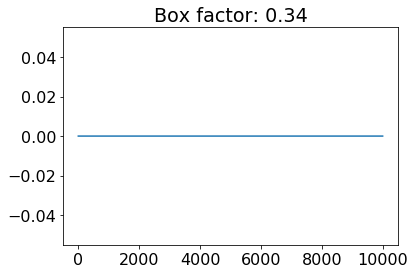

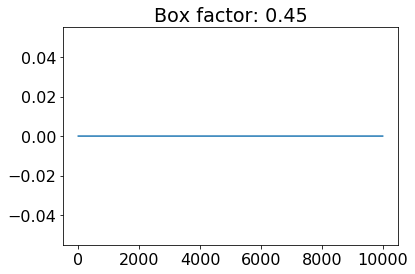

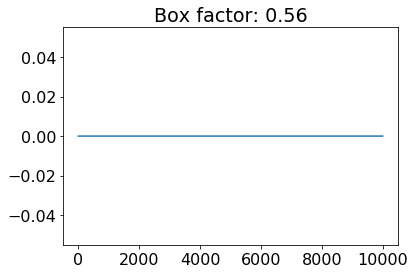

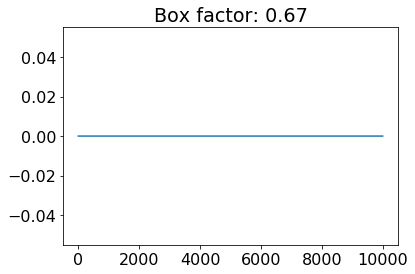

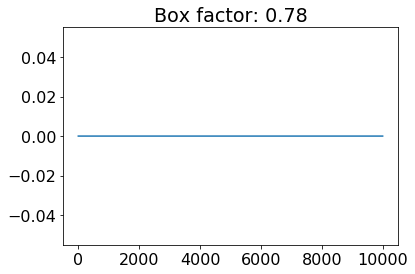

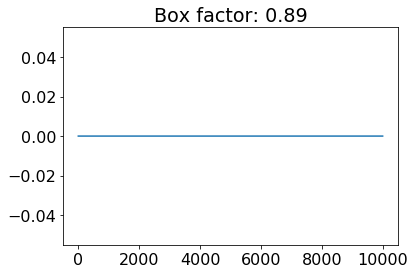

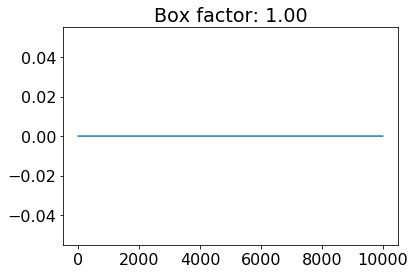

In [26]:
for k,box in enumerate(Box_sizes):
    plt.plot( range(len(DATA_b_massindp[k][:])) , DATA_b_massindp[k][:])
    plt.title(r'Box factor: {:.2f}'.format(box))
    plt.show()

In [27]:
from ase.io.cube import read_cube_data
data, atoms = read_cube_data('../hco_100_md-ELECTRON_DENSITY-1_200.cube')

FileNotFoundError: [Errno 2] No such file or directory: '../hco_100_md-ELECTRON_DENSITY-1_200.cube'

In [17]:
#import ase.visualize.mlab as ase_mlab
#data = np.asarray(data)
#print(np.shape(data))


##import ase.visualize.mlab as ase_mlab
#contours=[1e-12]
#ase_mlab.plot(POS[200], data, contours)